In [32]:
import dicom
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import scipy.ndimage
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [33]:
data_dir = 'F:\\datasets\\science_bowl\\train\\1\\study\\2ch_21'
data_dir30 = 'F:\\datasets\\science_bowl\\train\\1\\study\\sax_12'
def get_files(file_dir):
    '''
    Args:
        file_dir: file directory
    Returns:
        list of file path
    '''
    dataset_path = []
    for root, dirs, files in os.walk(file_dir):
        for file in files:
            dataset_path.append(os.path.join(root,file))
    return dataset_path
imgs_path = get_files(data_dir)
imgs_path30 = get_files(data_dir30)

imgs_path[:10]
#labels_df = pd.read_csv('C:\\Users\\wu1114\\Documents\\Data_Science_Bowl\\train.csv\\train.csv')
#labels_df.head()

['F:\\datasets\\science_bowl\\train\\1\\study\\2ch_21\\IM-4572-0001.dcm',
 'F:\\datasets\\science_bowl\\train\\1\\study\\2ch_21\\IM-4572-0002.dcm',
 'F:\\datasets\\science_bowl\\train\\1\\study\\2ch_21\\IM-4572-0003.dcm',
 'F:\\datasets\\science_bowl\\train\\1\\study\\2ch_21\\IM-4572-0004.dcm',
 'F:\\datasets\\science_bowl\\train\\1\\study\\2ch_21\\IM-4572-0005.dcm',
 'F:\\datasets\\science_bowl\\train\\1\\study\\2ch_21\\IM-4572-0006.dcm',
 'F:\\datasets\\science_bowl\\train\\1\\study\\2ch_21\\IM-4572-0007.dcm',
 'F:\\datasets\\science_bowl\\train\\1\\study\\2ch_21\\IM-4572-0008.dcm',
 'F:\\datasets\\science_bowl\\train\\1\\study\\2ch_21\\IM-4572-0009.dcm',
 'F:\\datasets\\science_bowl\\train\\1\\study\\2ch_21\\IM-4572-0010.dcm']

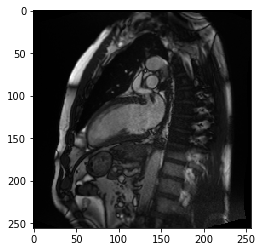

In [34]:
slices = [dicom.read_file(path) for path in imgs_path]
slices30 = [dicom.read_file(path) for path in imgs_path30]
# for slice in slices:
# #     print(slice.pixel_array.shape, len(slices))
#     plt.imshow(slice.pixel_array)
#     plt.show()
plt.imshow(slices[0].pixel_array, cmap='gray')
plt.show()

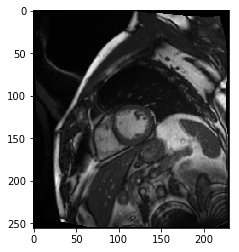

In [35]:
plt.imshow(slices30[0].pixel_array, cmap='gray')
plt.show()

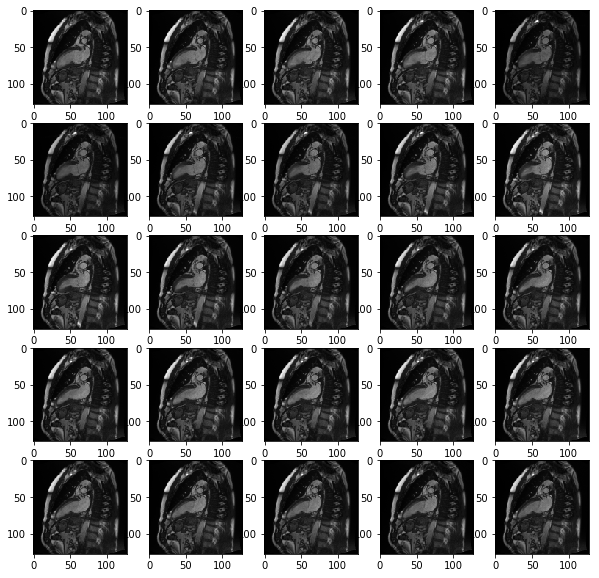

In [36]:
IMG_PX_SIZE = 128

fig = plt.figure(figsize=(10, 10))
for num,each_slice in enumerate(slices[:25]):
    y = fig.add_subplot(5,5,num+1)
    new_img = cv2.resize(np.array(each_slice.pixel_array),(IMG_PX_SIZE,IMG_PX_SIZE))
    y.imshow(new_img, cmap='gray')
plt.show()


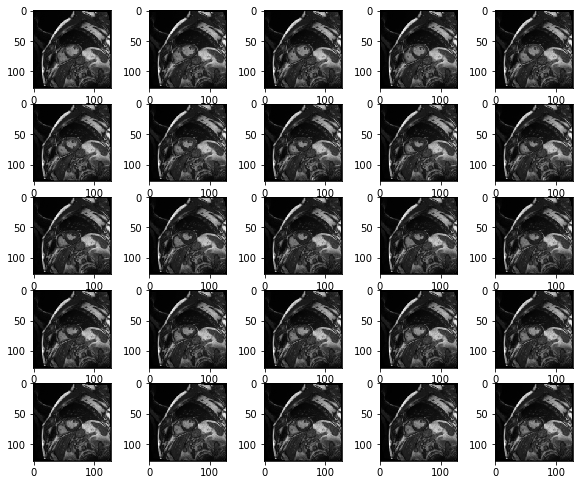

In [37]:
fig = plt.figure(figsize=(10, 10))
for num,each_slice in enumerate(slices30[:25]):
    y = fig.add_subplot(6,5,num+1)
    new_img = cv2.resize(np.array(each_slice.pixel_array),(IMG_PX_SIZE,IMG_PX_SIZE))
    y.imshow(new_img, cmap='gray')
plt.show()

In [38]:
# only save pixels
imgs = []
for each_slice in slices:
    new_img = cv2.resize(np.array(each_slice.pixel_array),(IMG_PX_SIZE,IMG_PX_SIZE))
    imgs.append(new_img)
imgs = np.array(imgs)

In [39]:
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    print([scan[0].SliceThickness])
    print(scan[0].PixelSpacing)
    spacing = np.array([scan[0].SliceThickness] + scan[0].PixelSpacing, dtype=np.float32)

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    
    return image, new_spacing

pix_resampled, spacing = resample(imgs, slices, [1,1,1])


['6']
['1.5625', '1.5625']


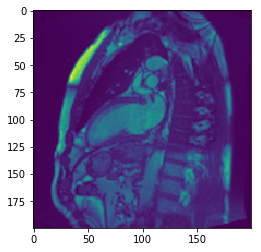

In [40]:
plt.imshow(pix_resampled[1])
plt.show()

In [41]:
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

In [42]:
slices[0]

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'M', 'RETRO', 'NORM', 'DIS2D']
(0008, 0013) Instance Creation Time              TM: '144829.031000'
(0008, 0016) SOP Class UID                       UI: MR Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.9590.100.1.2.237269495213057556008672336892692799463
(0008, 0030) Study Time                          TM: '141855.484000'
(0008, 0031) Series Time                         TM: '144829'
(0008, 0032) Acquisition Time                    TM: '144819.942500'
(0008, 0060) Modality                            CS: 'MR'
(0008, 0070) Manufacturer                        LO: 'SIEMENS'
(0008, 103e) Series Description                  LO: '2ch'
(0008, 1090) Manufacturer's Model Name           LO: 'Aera'
(0008, 1140)  Referenced Image Sequence   3 item(s) ---- 
   (0008, 1150) Referenced SOP Class UID            UI: MR Image Storag

In [43]:
first_patient_pixels = get_pixels_hu(slices)
plt.hist(first_patient_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

AttributeError: Dataset does not have attribute 'RescaleIntercept'.

In [ ]:
def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    
    verts, faces = measure.marching_cubes_classic(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()


In [ ]:
plot_3d(pix_resampled, 0)

In [ ]:
def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)

    counts = counts[vals != bg]
    vals = vals[vals != bg]

    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None

def segment_lung_mask(image, fill_lung_structures=True):
    
    # not actually binary, but 1 and 2. 
    # 0 is treated as background, which we do not want
    binary_image = np.array(image > -320, dtype=np.int8)+1
    labels = measure.label(binary_image)
    
    # Pick the pixel in the very corner to determine which label is air.
    #   Improvement: Pick multiple background labels from around the patient
    #   More resistant to "trays" on which the patient lays cutting the air 
    #   around the person in half
    background_label = labels[0,0,0]
    
    #Fill the air around the person
    binary_image[background_label == labels] = 2
    
    
    # Method of filling the lung structures (that is superior to something like 
    # morphological closing)
    if fill_lung_structures:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
            
            if l_max is not None: #This slice contains some lung
                binary_image[i][labeling != l_max] = 1

    
    binary_image -= 1 #Make the image actual binary
    binary_image = 1-binary_image # Invert it, lungs are now 1
    
    # Remove other air pockets insided body
    labels = measure.label(binary_image, background=0)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None: # There are air pockets
        binary_image[labels != l_max] = 0
 
    return binary_image

In [ ]:
segmented_lungs = segment_lung_mask(pix_resampled, False)
segmented_lungs_fill = segment_lung_mask(pix_resampled, True)

In [ ]:
segmented_lungs = segmented_lungs.astype('int16')
plt.imshow(segmented_lungs[2])
plt.show()